In [1]:
%matplotlib inline
from pysgpp import RegressionLearner, RegularGridConfiguration, AdpativityConfiguration, SLESolverConfiguration, \
RegularizationConfiguration, DataMatrix, DataVector

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src/')))
from sgpi.util import get_dataset, get_xy, get_r_squared, split, to_data_matrix

from sgpi import model
from sgpi.learner import SGRegressionLearner
import sqlalchemy as sa
from sqlalchemy import orm, func

import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def generate_data(dim, level, noiseStd, num):
    np.random.seed(42)
    grid_config = RegularGridConfiguration()
    grid_config.dim_ = dim
    grid_config.level_ = level
    grid_config.type_ = 6
    grid_config.t_ = 0.0

    adaptivity_config = AdpativityConfiguration()
    adaptivity_config.numRefinements = 0

    solver_config = SLESolverConfiguration()
    solver_config.type_ = 0
    solver_config.maxIterations_ = 50
    solver_config.threshold_ = 1e-5

    regularization_config = RegularizationConfiguration()
    regularization_config.type_ = 2
    regularization_config.exponentBase_ = 0.25
    regularization_config.lambda_ = 0.1

    estimator = RegressionLearner(grid_config, adaptivity_config, solver_config, solver_config, regularization_config)
    
    estimator.initializeWeights()
    X = to_data_matrix(np.random.random((num, dim)))
    y = np.matrix(estimator.predict(X).array()).T 
    if noiseStd != 0.0:
        y = y + np.matrix(np.random.normal(0,noiseStd, num)).T
    X = X.array()
    df = pd.DataFrame(np.append(X,y,axis=1)).reset_index(drop=False)
    df.columns = ['index'] + ['x' + str(x) for x in range(0,dim)] + ['y']
    return df, estimator.getWeights().array()

def save_data(dim, level, noiseStd, num, filename):
    df, _ = generate_data(dim, level, noiseStd, num)
    prefix = '../datasets/processed/diagonal_test/'
    df.drop(['index'], axis=1).to_csv(os.path.join(prefix, filename), index=None)

,index,x0,x1,y
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,0.494333,0.500694,-0.216789
std,577.494589,0.293217,0.287527,1.050650
min,0.000000,0.000012,0.001474,-3.707812
25%,499.750000,0.232164,0.254778,-0.785116
50%,999.500000,0.498312,0.502042,-0.033512
75%,1499.250000,0.750999,0.748120,0.508099
max,1999.000000,0.999414,0.999718,2.040965


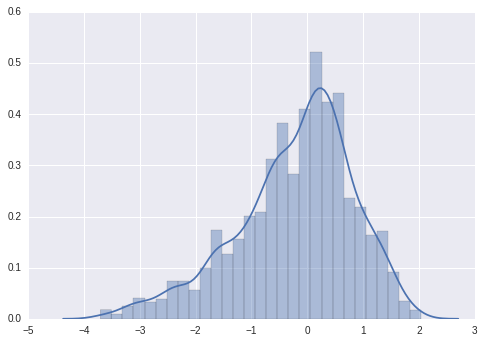

In [3]:
df, weights = generate_data(2, 5, 0, 2000)
_, y = get_xy(df)
signal_std = y.std()
sns.distplot(y)
df.describe()

In [4]:
save_data(2,5,signal_std / 4.0, 2000, 'diag_test_low_noise.csv')
save_data(2,5,signal_std / 2.0 , 2000, 'diag_test_medium_noise.csv')
save_data(2,5,signal_std, 2000, 'diag_test_high_noise.csv')
save_data(2,5,signal_std *2.0, 2000, 'diag_test_very_high_noise.csv')

In [5]:
np.std(weights), np.mean(weights), np.median(weights)

(0.17638010595214174, -0.021993917971553652, -0.014888090315905243)

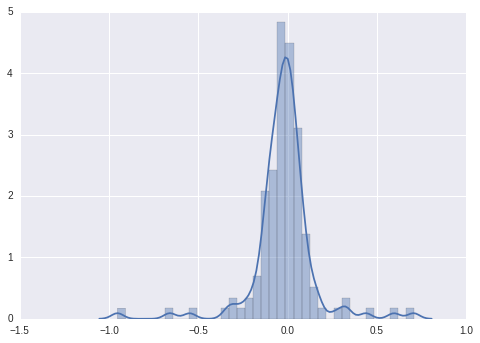

In [6]:
sns.distplot(weights)

# RMSE of Weights
Get all experiment results for diag_test results, train again with complete training set and evaluate the RMSE of the weights

In [7]:
def calculate_weights(res):
    df = get_dataset(res.experiment.dataset)
    train, test = split(df)
    X_train, y_train = get_xy(train)
    X_test, y_test = get_xy(test)
    estimator = SGRegressionLearner(res.grid_config, res.regularization_config, res.solver_config, res.final_solver_config, res.adaptivity_config)
    estimator.fit(X_train, y_train)
    return res.experiment.dataset, res.regularization_config.exponent_base, estimator.get_weights()

In [8]:
# First get the estimators with the best CV-MSE from the database
ses = model.make_session()
best_results = ses.query(model.Result, func.min(model.Result.validation_mse)).\
    group_by(model.Result.experiment_id).\
    join(model.RegularizationConfig).\
    group_by(model.RegularizationConfig.exponent_base).\
    join(model.Experiment).\
    filter(model.Experiment.dataset.contains('diag_test'))

In [9]:
def calculate_best_weights(results):
    weights = []
    for res in best_results:
        weights.append(calculate_weights(res[0]))
    return weights

In [10]:
best_weights = calculate_best_weights(best_results)

In [11]:
def calculate_weight_RMSE(weights, ideal_weights):
    errors = []
    for (d, e, w) in weights:
        diff = np.subtract(w, ideal_weights)
        se = np.square(diff).sum()
        mse = (1.0/ideal_weights.shape[0]) * se
        rmse = np.sqrt(mse)
        errors.append((d, e, rmse))        
    return pd.DataFrame(errors, columns=["dataset", "exponent_base", "weight RMSE"])

In [12]:
calculate_weight_RMSE(best_weights, weights)

,dataset,exponent_base,weight RMSE
0,diag_test_low_noise,0.25,0.115252
1,diag_test_low_noise,0.50,0.114847
2,diag_test_low_noise,1.00,0.084916
3,diag_test_low_noise,1.50,0.070288
4,diag_test_medium_noise,0.25,0.221306
5,diag_test_medium_noise,0.50,0.158320
6,diag_test_medium_noise,1.00,0.112541
7,diag_test_medium_noise,1.50,0.096089
8,diag_test_high_noise,0.25,0.238721
9,diag_test_high_noise,0.50,0.180485


# Graph results for each experiment

In [13]:
all_results = ses.query(model.Result).\
    join(model.Experiment).\
    filter(model.Experiment.dataset.contains('diag_test'))

In [14]:
experiment_ids = ses.query(model.Result.experiment_id).\
    distinct(model.Result.experiment_id).\
    join(model.Experiment).\
    filter(model.Experiment.dataset.contains('diag_test')).\
    all()

In [15]:
def get_results_per_experiment(all_results, experiment_ids):
    res_per_exp = []
    for rid, in experiment_ids:
        res = all_results.filter(model.Result.experiment_id == rid).all()
        res_per_exp.append(res)
    return res_per_exp  

def get_df_for_experiment(experiment):
    results = []
    for result in experiment:
        results.append((result.validation_mse, result.regularization_config.lambda_reg,\
                        result.regularization_config.exponent_base,\
                        result.experiment.dataset))
    return pd.DataFrame(results, columns=["mse", "lambda_reg", "exponent_base", "dataset"])

In [16]:
dfs = []
for exp in get_results_per_experiment(all_results, experiment_ids):
    df = get_df_for_experiment(exp)
    dfs.append(df)

In [17]:
def get_snr_by_dataset(dataset):
    snrs = {'diag_test_low_noise' : 4,
            'diag_test_medium_noise' : 2,
            'diag_test_high_noise' : 1,
            'diag_test_very_high_noise': 0.5}
    return snrs[dataset]

def plot_experiment(df):
    fig, ax = plt.subplots()
    groups = df.groupby('exponent_base')
    for name, group in groups:
        ax.loglog(group.lambda_reg, group.mse, marker='o', linestyle='', ms=4, label=name)
    ax.legend()
    ax.margins(0.05)
    ax.invert_xaxis()
    ax.set_xlabel("Regularization lambda")
    ax.set_ylabel("CV-MSE")
    dataset = df['dataset'][0]
    ax.set_title("Errors for " + dataset + " with a SNR of " + str(get_snr_by_dataset(dataset)))
    plt.show()

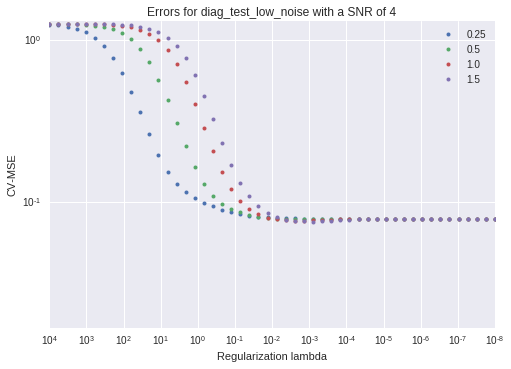

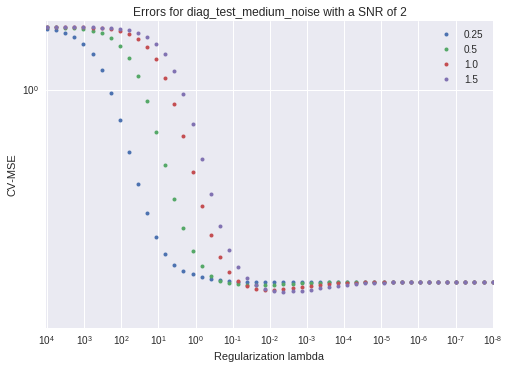

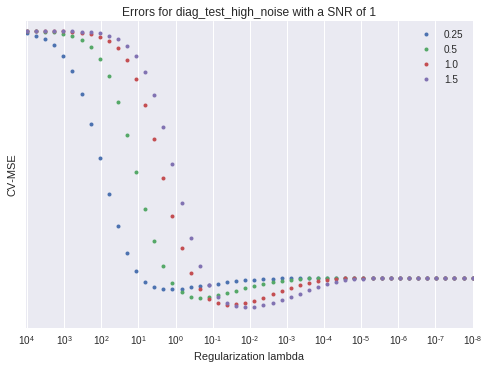

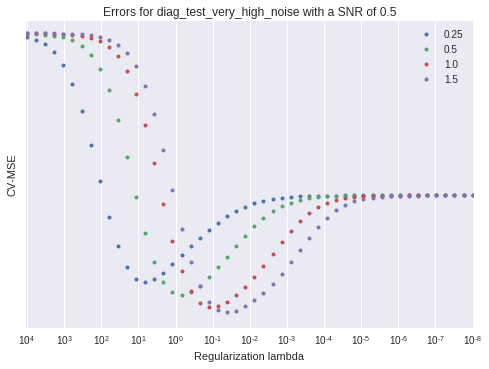

In [18]:
for df in dfs:
    plot_experiment(df)

In [19]:
def print_best_results(best_results):
    results = []
    for result, cv_err in best_results:
        reg = result.regularization_config
        results.append((result.experiment.dataset, reg.lambda_reg, reg.exponent_base, cv_err))
    return pd.DataFrame(results, columns=["dataset", "lambda", "exponent_base", "cv_error"])
print_best_results(best_results)

,dataset,lambda,exponent_base,cv_error
0,diag_test_low_noise,0.000256,0.25,0.079226
1,diag_test_low_noise,0.001389,0.50,0.079037
2,diag_test_low_noise,0.002442,1.00,0.077208
3,diag_test_low_noise,0.000791,1.50,0.076201
4,diag_test_medium_noise,0.013257,0.25,0.316665
5,diag_test_medium_noise,0.023300,0.50,0.311028
6,diag_test_medium_noise,0.007543,1.00,0.302795
7,diag_test_medium_noise,0.004292,1.50,0.299585
8,diag_test_high_noise,1.206793,0.25,1.233186
9,diag_test_high_noise,0.222300,0.50,1.208169
